# 量子随机基准测试（Quantum randomized benchmarking）
量子随机基准测试，是一个量子噪声的学习方法，也可以理解为是一种量子噪声的刻画方法，可以获得运行Clifford门引入的平均噪声。

随机基准测试方法可以简要概况为如下步骤：
1. 选择一系列逐渐增加的深度 $d = [m_0,m_1,...,m_n]$，在这些深度下正确概率 $p_{\text{true}}$ 会逐渐衰减，即随着深度增加，错误概率增加，正确概率减小。
2. 对于每个深度 $d$，生成许多随机序列，其中每个门表示一个随机的克利福德门。当 $d=m$ 时，序列为 $[C^{-1}, C_m, C_{m-1}, \dots, C_2, C_1]$。
3. 对于每个序列，通过 $N$ 次运行电路并且测量，分析测量结果分布，计算对应的正确概率 $p_{\text{true}}$。
4. 利用上述指数衰减模型，采用最小二乘法等拟合方法，拟合对应的深度 $m$ 以及其对应的正确概率 $p_{\text{true}}$，从而可以得到 $A_0$、$B_0$ 以及衰减参数 $\lambda$。
5. 衰减参数即为我们想要的去极化参数。

randomized benchmarking在qiskit中已经实现，因此这里暂时直接调用qiskit中已经实现的函数，后续考虑自己实现。

In [4]:
import numpy as np
from qiskit_experiments.library import StandardRB

from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import FakePerth

构建含噪噪声的模拟器后端，这里选用Qiskit中提供了含噪模拟后端。如果无法导入FakePerth，可能是qiskit版本问题，可以尝试选择同样的qiskit版本。

In [5]:
backend = AerSimulator.from_backend(FakePerth())

设置随机clifford电路深度、采样次数、随机种子以及执行的物理量子比特位置。

In [6]:
list_m = np.arange(1, 800, 200)
num_samples = 10
seed = 1010
qubits = [0]

在0号量子比特上运行RB实验，构建所需运行的量子电路。

In [7]:
# Run an RB experiment on qubit 0
exp1 = StandardRB(qubits, list_m, num_samples=num_samples, seed=seed)

将量子电路提交到含噪的qiskit后端，并执行。

In [8]:
expdata1 = exp1.run(backend, seed=seed).block_for_results()

将结果进行拟合分析，得到RB的结果。

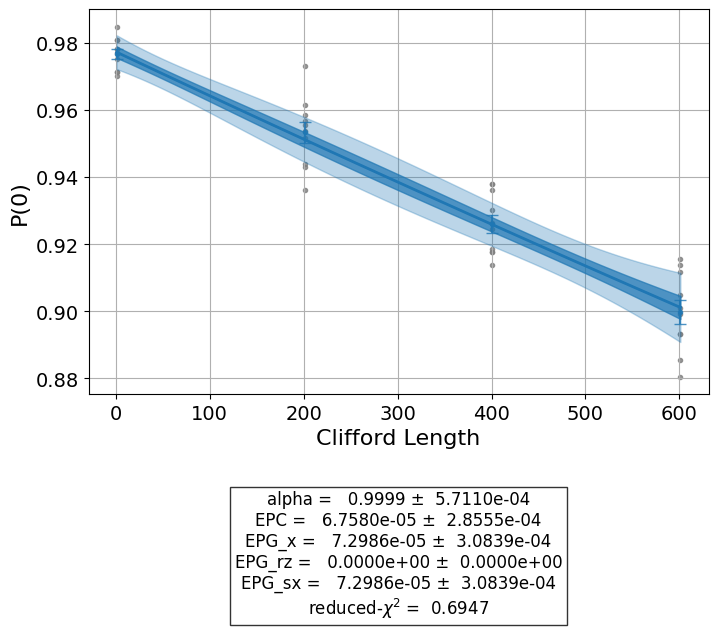

-------------------0-------------
AnalysisResult
- name: @Parameters_RBAnalysis
- value: CurveFitResult:
 - fitting method: least_squares
 - number of sub-models: 1
  * F_rb_decay(x) = a * alpha ** x + b
 - success: True
 - number of function evals: 143
 - degree of freedom: 1
 - chi-square: 0.6947444146474945
 - reduced chi-square: 0.6947444146474945
 - Akaike info crit.: -1.0020224435280625
 - Bayesian info crit.: -2.843139360168391
 - init params:
  * a = 0.476920426965986
  * alpha = 0.9997065775479607
  * b = 0.5
 - fit params:
  * a = 0.9773549524952135 ± 3.9862584076972505
  * alpha = 0.9998648404160293 ± 0.0005710976775704452
  * b = 2.0225275553453607e-15 ± 3.986764852763988
 - correlations:
  * (a, b) = -0.9999999181040651
  * (alpha, b) = -0.9999439607290993
  * (a, alpha) = 0.999941213791448
- quality: good
- device_components: ['Q0']
- verified: False
-------------------1-------------
AnalysisResult
- name: alpha
- value: 0.9999+/-0.0006
- χ²: 0.6947444146474945
- quality:

In [12]:
results1 = expdata1.analysis_results()

display(expdata1.figure(0))
for i in range(len(results1)):
    print(f"-------------------{i}-------------")
    print(results1[i])

通过上述可知，我们拟合了一个指数衰减模型，其对应的参数为：
a = 0.9773549524952135 
b = 2.0225275553453607e
alpha = 0.9998648404160293 
其中，a、b、alpha分别对应于RB模型中的三个参数，a、b为常数，alpha对应于去极化参数。